In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




In [2]:
def show(data, const_axis, const_val, x_axis, y_axis, z_axis, colour="gray", z_min=-2, z_max=2, title=None):
    data = data.loc[data[const_axis] == const_val]
    data = data.pivot(columns=x_axis, index=y_axis, values=z_axis)
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=colour, vmin=z_min, vmax=z_max)    

    plt.title(title)
    plt.tight_layout()
    return plt.show(fig)

In [3]:
full_data = pd.read_parquet("Sleipner_4D_Seismic_Small.parquet.gzip", engine = "pyarrow")
# Calculate differences
full_data['01-94'] = full_data['01'] - full_data['94']
full_data['06-01'] = full_data['06'] - full_data['01']
full_data['06-94'] = full_data['06'] - full_data['94']

display(full_data)


,z,x,y,94,01,06,01-94,06-01,06-94
0,0.0,956,1716,0.000026,-0.006091,-0.005390,-0.006117,0.000700,-0.005417
1,0.0,956,1717,0.002181,-0.015860,0.009069,-0.018041,0.024929,0.006889
2,0.0,956,1718,0.000025,-0.009283,-0.006776,-0.009308,0.002507,-0.006801
3,0.0,956,1719,-0.003922,-0.009160,-0.004944,-0.005239,0.004216,-0.001022
4,0.0,956,1720,0.000031,-0.010252,-0.008233,-0.010283,0.002019,-0.008264
...,...,...,...,...,...,...,...,...,...
64241995,1498.0,1299,1960,-0.285229,-0.257875,-0.349266,0.027354,-0.091392,-0.064038
64241996,1498.0,1299,1961,-0.322909,-0.257242,-0.310981,0.065667,-0.053739,0.011928
64241997,1498.0,1299,1962,-0.232337,-0.178725,-0.181341,0.053612,-0.002616,0.050996
64241998,1498.0,1299,1963,-0.205845,-0.152657,-0.102178,0.053188,0.050479,0.103667


In [5]:
# For example, using standard deviation as a threshold:
STD_TRESHOLD = 5
threshold = full_data[['01-94', '06-01', '06-94']].std() * STD_TRESHOLD  # Change 2 to your chosen number of standard deviations
# significant_changes = data[(data['01-94'].abs() > threshold['01-94']) |
#                            (data['06-01'].abs() > threshold['06-01']) |
#                            (data['06-94'].abs() > threshold['06-94'])]

significant_changes = full_data[(full_data['01-94'].abs() > threshold['01-94'])]
significant_changes = significant_changes.drop(['94', '01', '06'], axis=1)

print("\nSignificant Changes (Based on Threshold):")
print(significant_changes.describe())



Significant Changes (Based on Threshold):
                   z              x              y          01-94  \
count  176549.000000  176549.000000  176549.000000  176549.000000   
mean      732.609644    1142.988241    1842.545350      -0.166112   
std       380.597606      59.448958      38.286643       1.009476   
min        88.000000     957.000000    1718.000000      -2.831950   
25%       128.000000    1112.000000    1830.000000      -0.922190   
50%       938.000000    1145.000000    1846.000000      -0.713943   
75%       966.000000    1174.000000    1865.000000       0.808215   
max      1458.000000    1299.000000    1960.000000       2.734668   

               06-01          06-94  
count  176549.000000  176549.000000  
mean       -0.022174      -0.188286  
std         1.003928       0.827496  
min        -3.758392      -3.388004  
25%        -0.604534      -0.755018  
50%         0.019519      -0.163467  
75%         0.692857       0.382721  
max         3.013892       2.85

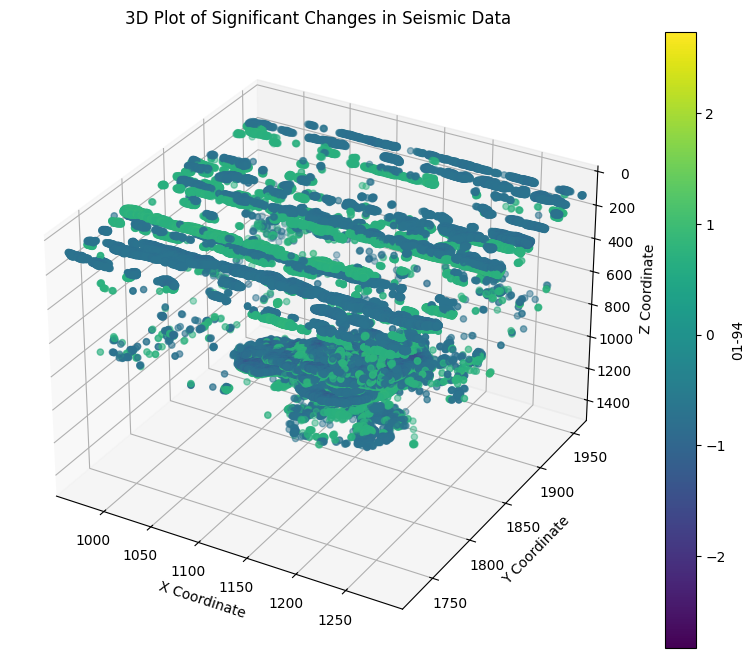

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for significant changes with color based on '01-94' feature
scatter = ax.scatter(significant_changes['x'], significant_changes['y'], significant_changes['z'], c=significant_changes['01-94'], cmap='viridis', marker='o')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('3D Plot of Significant Changes in Seismic Data')

# Adding a colorbar to interpret the '01-94' values
colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('01-94')
ax.set_xlim(full_data['x'].min(), full_data['x'].max())
ax.set_ylim(full_data['y'].min(), full_data['y'].max())
ax.set_zlim(full_data['z'].min(), full_data['z'].max())
ax.invert_zaxis()

plt.show()


In [20]:

# Calculate the standard deviation thresholds
STD_THRESHOLD = 7.5
threshold = full_data[['01-94', '06-01', '06-94']].std() * STD_THRESHOLD

# Find significant changes
significant_changes = full_data[(full_data['01-94'].abs() > threshold['01-94'])]

# Drop other columns if they are not needed
significant_changes = significant_changes.drop(['94', '01', '06'], axis=1)

# Filter out rows where 'z' is not between the 25th and 75th percentile
significant_changes = significant_changes[(significant_changes['z'] >= full_data['z'].quantile(0.3)) & 
                                          (significant_changes['z'] <= full_data['z'].quantile(0.7))]

# Display summary statistics of the filtered significant changes
print("\nSignificant Changes (Based on Threshold) within 25-75th Percentile of 'z':")
print(significant_changes.describe())



Significant Changes (Based on Threshold) within 25-75th Percentile of 'z':
                  z             x             y         01-94         06-01  \
count  52925.000000  52925.000000  52925.000000  52925.000000  52925.000000   
mean     945.599811   1140.360453   1851.843193     -0.388961      0.032759   
std       38.704439     32.305860     18.916671      1.334061      1.297302   
min      648.000000   1050.000000   1736.000000     -2.831950     -3.638985   
25%      920.000000   1116.000000   1837.000000     -1.401217     -1.009094   
50%      946.000000   1143.000000   1852.000000     -1.124519      0.241982   
75%      962.000000   1167.000000   1868.000000      1.152426      1.070548   
max     1048.000000   1206.000000   1892.000000      2.734668      3.013892   

              06-94  
count  52925.000000  
mean      -0.356202  
std        0.882905  
min       -3.388004  
25%       -0.905982  
50%       -0.348005  
75%        0.199702  
max        2.758659  


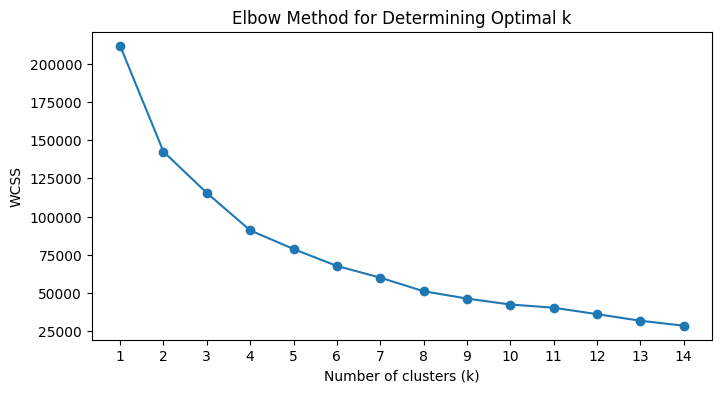

In [30]:
# Assuming your significant changes DataFrame is named 'significant_changes'

# Scale the data
scaler = StandardScaler()
significant_changes_scaled = scaler.fit_transform(significant_changes[['x', 'y', 'z', '01-94']])

# Determine the range of k values to try
k_values = range(1, 15)  # You can choose a different range based on your dataset

# Calculate WCSS for each k
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(significant_changes_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_values, wcss, 'o-')
plt.title('Elbow Method for Determining Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.show()


In [31]:
# Choose the k value where the elbow is located (the point after which the inertia decrease is linear)
optimal_k = 3

# Segment the data using the optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans_optimal.fit_predict(significant_changes_scaled)

# Add the cluster assignment back to the original data
significant_changes['Cluster'] = clusters

# Now you can analyze 'significant_changes' to see the segmented sources and sinks


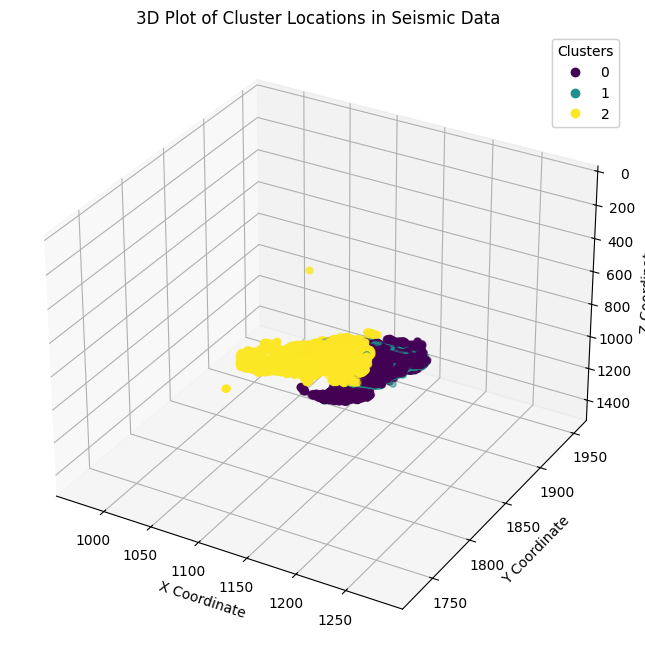

In [32]:

# Use this code with the actual clustered DataFrame
# Ensure the DataFrame includes 'x', 'y', 'z' coordinates and a 'Cluster' column

# Plotting the cluster locations
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Differentiating clusters by color
scatter = ax.scatter(significant_changes['x'], significant_changes['y'], significant_changes['z'],
                     c=significant_changes['Cluster'], cmap='viridis', marker='o')

# Adding labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('3D Plot of Cluster Locations in Seismic Data')

ax.set_xlim(full_data['x'].min(), full_data['x'].max())
ax.set_ylim(full_data['y'].min(), full_data['y'].max())
ax.set_zlim(full_data['z'].min(), full_data['z'].max())
ax.invert_zaxis()

# Adding a legend for clusters
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.show()
